In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rc('text', usetex=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('source_data/included/figure.style')

In [2]:
counts_table = pd.read_csv('source_data/included/SB1354_Fusion_MaxQuant_LFQ_intensity_wt_metG.txt',sep='\t',index_col=0)
counts_table = np.log2(counts_table+1)


In [3]:
x = StandardScaler().fit_transform(counts_table.transpose())
pca = PCA()
principalComponents = pca.fit_transform(x)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1','PC2','PC3','PC4'])
principalDf.index = counts_table.columns
principalDf['type'] = principalDf.index.str.replace('_1','').str.replace('_2','').str.replace('_3','')
pca.explained_variance_ratio_

[5.10927872e-01 1.12451090e-01 7.44225700e-02 4.94957036e-02
 4.74271412e-02 4.22919814e-02 3.75466671e-02 3.40459432e-02
 3.29296787e-02 3.11182811e-02 2.73430713e-02 1.41202053e-32]
1.0


array([0.51092787, 0.11245109, 0.07442257, 0.0494957 ])

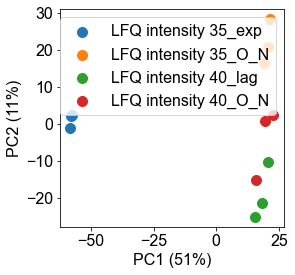

In [4]:
fig,ax = plt.subplots(figsize=(4,4))
for ty in principalDf['type'].unique():
    ax.scatter(-principalDf.loc[principalDf['type']==ty,'PC1'],principalDf.loc[principalDf['type']==ty,'PC2'],label=ty,s=100)
ax.legend()
ax.set_xlabel('PC1 (' + str(int(100*np.round(pca.explained_variance_ratio_[0],2))) + '%)')
ax.set_ylabel('PC2 (' + str(int(100*np.round(pca.explained_variance_ratio_[1],2))) + '%)')

plt.savefig('figures/figED7c.pdf')


In [5]:
table = pd.read_csv('source_data/included/dep_diffexp.txt',sep='\t')
table.index = table['ID']
bnum_table = pd.read_csv('source_data/included/uniprot_to_bnum_table.txt',sep='\t',index_col=0)
bnum_table = bnum_table.drop_duplicates()
bnum_table.index = bnum_table['uniprot']

table = table.merge(bnum_table,left_index=True,right_index=True,how='left')
unassigned = table.loc[table['bnum'].isna()]

bnum_table_2 = pd.read_csv('source_data/included/ecoli_bnum_table_updated_2.txt',sep='\t',index_col=0)
bnum_table_2.index = bnum_table_2['gene']
unassigned.index = unassigned['name']
unassigned = unassigned.drop('bnum',axis=1).merge(bnum_table_2,left_index=True,right_index=True,how='left').drop('gene',axis=1)
unassigned.index = unassigned['ID']

table.loc[table['bnum'].isna()] = unassigned
table.loc[table['bnum'].isna()]
table.loc['Q46796','bnum'] = 'b2862'
table.loc['A0A385XJE6','bnum'] = 'b3505'
table.loc['P0DTT0','bnum'] = 'b3871'
table.loc['P0DP89','bnum'] = 'b4488'
proteomics_diffexp = table.copy()
proteomics_diffexp.index = proteomics_diffexp['bnum']



SpearmanrResult(correlation=0.06937011544867905, pvalue=0.0012453081890838272)
2163
35


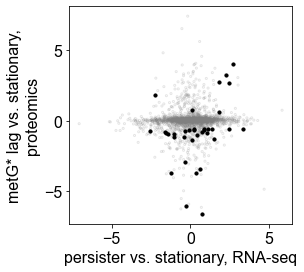

In [6]:
bnum_table = pd.read_csv('source_data/included/ecoli_bnum_table_updated_2.txt',sep='\t',index_col=0)
bnum_table = bnum_table.drop_duplicates()
bnum_table.index = bnum_table['gene']

id1 = '2'
id2 = '1'
FDR = 0.05
filename = 'source_data/generated/v2_clust' + id1 + '_vs_' + id2 + '_markers_for_fig1.txt' # saved in fig1_markers.R
table = pd.read_csv(filename,sep='\t',index_col=0)
table.index = table['Row.names']
table = table.drop('Row.names',axis=1)
table = table.merge(bnum_table,left_index=True,right_index=True)
table.index = table['bnum']
table['less'] = -table['less']
signed_p = []
for h,l in zip(table['greater'],table['less']):
    if abs(h)<=abs(l):
        signed_p.append(h + (10**-300))
    elif abs(l)<abs(h):
        signed_p.append(l - (10**-300))
    else:
        print('error')
table['signed_p'] = signed_p
table['fixed_signif'] = (abs(table['signed_p']).sort_values()<FDR*np.arange(1,len(table)+1)/len(table)).astype(int)
table['fixed_signif'] = (table['fixed_signif'] * (table['signed_p']/abs(table['signed_p']))).astype(int)
RNA_table = table.copy()

fig,ax = plt.subplots(figsize=(4,4))

merged = RNA_table.merge(proteomics_diffexp[['X40_lag_vs_X40_O_N_ratio','X40_lag_vs_X40_O_N_p.val','X40_lag_vs_X40_O_N_significant']],left_index=True,right_index=True)
x = merged['logFC']
y = merged['X40_lag_vs_X40_O_N_ratio']
ax.scatter(x,y,s=4,alpha=0.2,facecolors='none', edgecolors='grey')
print(st.spearmanr(x,y))
print(len(y))
merged = merged.loc[merged['X40_lag_vs_X40_O_N_significant']]

x = merged['logFC']
y = merged['X40_lag_vs_X40_O_N_ratio']
ax.scatter(x,y,s=10,alpha=1,facecolors='k', edgecolors='k')

gene = 'b3041'
#ax.scatter(x[gene],y[gene])
print(len(y))

ax.set_xlabel('persister vs. stationary, RNA-seq')
ax.set_ylabel('metG* lag vs. stationary,\nproteomics')

plt.savefig('figures/figED7d.pdf')


SpearmanrResult(correlation=0.5997945737895849, pvalue=3.1998140454590123e-211)
2160
358


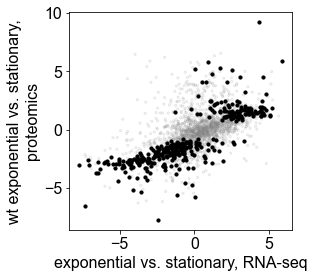

In [7]:
bnum_table = pd.read_csv('source_data/included/ecoli_bnum_table_updated_2.txt',sep='\t',index_col=0)
bnum_table = bnum_table.drop_duplicates()
bnum_table.index = bnum_table['gene']

FDR = 0.01
filename = 'source_data/generated/v4_clust1_vs_5.txt' # saved in fig1_markers.R
table = pd.read_csv(filename,sep='\t',index_col=0)
table.index = table['Row.names']
table = table.drop('Row.names',axis=1)
table = table.merge(bnum_table,left_index=True,right_index=True)
table.index = table['bnum']
table['less'] = -table['less']
signed_p = []
for h,l in zip(table['greater'],table['less']):
    if abs(h)<=abs(l):
        signed_p.append(h + (10**-300))
    elif abs(l)<abs(h):
        signed_p.append(l - (10**-300))
    else:
        print('error')
table['signed_p'] = signed_p
table['fixed_signif'] = (abs(table['signed_p']).sort_values()<FDR*np.arange(1,len(table)+1)/len(table)).astype(int)
table['fixed_signif'] = (table['fixed_signif'] * (table['signed_p']/abs(table['signed_p']))).astype(int)
RNA_table = table.copy()

fig,ax = plt.subplots(figsize=(4,4))

merged = RNA_table.merge(proteomics_diffexp[['X35_exp_vs_X35_O_N_ratio','X35_exp_vs_X35_O_N_significant']],left_index=True,right_index=True)
x = -merged['logFC']
y = merged['X35_exp_vs_X35_O_N_ratio']
ax.scatter(x,y,s=4,alpha=0.2,facecolors='none', edgecolors='grey')
print(st.spearmanr(x,y))
print(len(y))
merged = merged.loc[merged['X35_exp_vs_X35_O_N_significant']]

x = -merged['logFC']
y = merged['X35_exp_vs_X35_O_N_ratio']
ax.scatter(x,y,s=10,alpha=1,facecolors='k', edgecolors='k')
print(len(y))

ax.set_xlabel('exponential vs. stationary, RNA-seq')
ax.set_ylabel('wt exponential vs. stationary,\nproteomics')

plt.savefig('figures/figED7e.pdf')


SpearmanrResult(correlation=0.49719844273054914, pvalue=1.931170731910581e-135)
2163
358


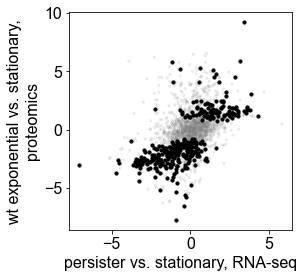

In [8]:
bnum_table = pd.read_csv('source_data/included/ecoli_bnum_table_updated_2.txt',sep='\t',index_col=0)
bnum_table = bnum_table.drop_duplicates()
bnum_table.index = bnum_table['gene']

id1 = '2'
id2 = '1'
FDR = 0.05
filename = 'source_data/generated/v2_clust' + id1 + '_vs_' + id2 + '_markers_for_fig1.txt' # saved in fig1_markers.R

table = pd.read_csv(filename,sep='\t',index_col=0)
table.index = table['Row.names']
table = table.drop('Row.names',axis=1)
table = table.merge(bnum_table,left_index=True,right_index=True)
table.index = table['bnum']
table['less'] = -table['less']
signed_p = []
for h,l in zip(table['greater'],table['less']):
    if abs(h)<=abs(l):
        signed_p.append(h + (10**-300))
    elif abs(l)<abs(h):
        signed_p.append(l - (10**-300))
    else:
        print('error')
table['signed_p'] = signed_p
table['fixed_signif'] = (abs(table['signed_p']).sort_values()<FDR*np.arange(1,len(table)+1)/len(table)).astype(int)
table['fixed_signif'] = (table['fixed_signif'] * (table['signed_p']/abs(table['signed_p']))).astype(int)
RNA_table = table.copy()

fig,ax = plt.subplots(figsize=(4,4))

merged = RNA_table.merge(proteomics_diffexp[['X35_exp_vs_X35_O_N_ratio','X35_exp_vs_X35_O_N_significant']],left_index=True,right_index=True)
x = merged['logFC']
y = merged['X35_exp_vs_X35_O_N_ratio']
ax.scatter(x,y,s=4,alpha=0.2,facecolors='none', edgecolors='grey')
print(st.spearmanr(x,y))
print(len(y))

merged = merged.loc[merged['X35_exp_vs_X35_O_N_significant']]

x = merged['logFC']
y = merged['X35_exp_vs_X35_O_N_ratio']
ax.scatter(x,y,s=10,alpha=1,facecolors='k', edgecolors='k')
print(len(y))

ax.set_xlabel('persister vs. stationary, RNA-seq')
ax.set_ylabel('wt exponential vs. stationary,\nproteomics')

plt.savefig('figures/figED7f.pdf')
